In [1]:

%pprint
%matplotlib inline
import sys
if (osp.join('..', 'py') not in sys.path): sys.path.insert(1, osp.join('..', 'py'))
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
import os
from pandas import DataFrame, Series
import re

freq = 990

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 4 seconds


In [2]:

def do_cypher_tx(tx, file_name):
    cypher_str = """
        // Get the HTML strings that are Job Titles
        CALL {
            MATCH (np1:NavigableParents)-[r:NEXT]->(np2:NavigableParents)
            WHERE
                (np1.is_header = false) AND
                (np1.is_job_title = true) AND
                (r.file_name = $file_name)
            RETURN
                r.file_name AS file_name,
                NULL AS left_navigable_parent,
                LEFT(np1.navigable_parent, 50) AS middle_navigable_parent,
                LEFT(np2.navigable_parent, 50) AS right_navigable_parent
            
            UNION
            
            MATCH (np1:NavigableParents)-[r:NEXT]->(np2:NavigableParents)
            WHERE
                (np2.is_header = false) AND
                (np2.is_job_title = true) AND
                (r.file_name = $file_name)
            RETURN
                r.file_name AS file_name,
                LEFT(np1.navigable_parent, 50) AS left_navigable_parent,
                LEFT(np2.navigable_parent, 50) AS middle_navigable_parent,
                NULL AS right_navigable_parent
        }
        RETURN file_name, left_navigable_parent, middle_navigable_parent, right_navigable_parent;"""
    
    return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'file_name': file_name})]

In [3]:

import pyperclip

SUBSTRS_LIST = [
    'Hire', 'Denver', 'VA', 'Accenture', 'Position', 'Hire', 'BA', 'Job', 'COM', 'AMAZON', 'AAA', 'Los Angeles', 'New', 'United States', 'NJ', 'hybrid', 'Lincoln Laboratory', 'MIT',
    'contract', 'NY', 'San', 'Inc', 'on', 'with', 'CO', 'Hybrid', 'term', 'OR', 'US', 'or', 'Boston', 'in', 'INC', 'MA', 'MD', 'CA', 'Washington', 'Rockville', 'ONSITE', 'Air',
    'Cambridge', 'Traffic', 'Marlborough', 'App', 'USA', 'C', 'UNIX', 'York', 'Role', 'Salem', 'Texas', 'Oregon', 'Worcester', 'Jose', 'Columbia', 'Francisco', 'Minneapolis', 'MN',
    'East Coast', 'Atlanta GA', 'Group', 'GOOGLE', 'Nashville TN', 'months', 'MARRIOTT INTERNATIONAL', 'Orlando FL', 'Virgin Island WI', 'VERIZON COMMUNICATIONS', 'Contract to',
    'Troy MI', 'Aurora', 'Fort PA', 'NASA', 'Greenbelt', 'Long Term Contract', 'Corporation', 'Selangor', 'Malaysia', 'Title', 'Location', 'No', 'China Lake', 'Toronto ON', 'Contract',
    'Internal', 'North America', 'Windsor Mill', 'Carson City NV', 'Portland', 'opening at sigma inc', 'UT', 'DC', 'Melville', 'Haven CT', 'Professional', 'Beaverton', 'Focus', 'Long',
    'Maharashtra', 'The Method'
]
pyperclip.copy(r'\b(' + '|'.join(SUBSTRS_LIST) + r')\b')
def f(x):
    x = re.sub(r'</?\w+[^>]*>', '', str(x)).split(':')[-1].strip().split('<')[0].strip().split('(')[0].strip()
    x = re.sub(r'[^A-Za-z /,]+', '', x)
    x = re.sub(r'\bOntologi\b', 'Ontology', x)
    x = re.sub(r'in \bOnto\b', ', Ontology', x)
    x = re.sub(r' */ *', ' / ', x)
    x = re.sub(r' *, *', ', ', x)
    x = re.sub(r'\bScientis\b', 'Scientist', x).replace('scientist', 'Scientist').replace('DataScientist', 'Data Scientist')
    x = re.sub(r'\bSr\b', 'Senior', x)
    x = re.sub(r'\bJr\b', 'Junior', x)
    x = re.sub(r' \bCopy\b', '', x)
    x = re.sub(r' \bREMOTE\b|\bREMOTE\b ', '', x, 0, re.IGNORECASE)
    x = re.sub(r' \bJob Opening\b ', '', x, 0, re.IGNORECASE)
    x = re.sub(r', etc', '', x)
    x = re.sub(r',? on\b', ',', x)
    x = re.sub(r'full ?stack', 'Full Stack', x)
    x = re.sub(r'\b(python|PYTHON)\b', 'Python', x)
    x = re.sub('Training( and)? Placement(, | on )?', '', x, 0, re.IGNORECASE)
    x = re.sub(r'\blead\b', 'Lead', x)
    x = re.sub(r'\bENGINEERDEEP\b', 'Engineer Deep', x)
    x = re.sub(r'\bsupport\b', 'Support', x, 0, re.IGNORECASE)
    x = re.sub(r'BANK OF America ', '', x, 0, re.IGNORECASE)
    x = re.sub(r' and yrs', '', x, 0, re.IGNORECASE)
    for sub_str in SUBSTRS_LIST:
        x = re.sub(r' \b' + sub_str + r'\b|\b' + sub_str + r'\b ', '', x)
    x = ' '.join([w.title() if (w.upper() == w) and (len(w) > 5) else w for w in x.split()])
    x = x.replace('Data Scientist Machine Learning Scientist Global Technologies', 'Machine Learning Scientist')
    x = x.replace('Data Scientist Machine Learning Scientist Open Systems', 'Machine Learning Scientist')
    x = x.replace('Data Scientist Machine Learning Scientist Deep Learning Computer Vision Scientist Global Technologies', 'Machine Learning Scientist')
    # if 'Scientist Machine' in x: display(x)
    x = x.replace('Statisticians', 'Statistician').replace('Developers', 'Developer').strip()

    return x

In [ ]:

# assert cu.SAVES_HTML_FOLDER == hau.SAVES_HTML_FOLDER
from pandas import concat
import enchant

# Loop through all files in the folder
file_name_job_titles_df = DataFrame([])
d = enchant.Dict('en_US')
for file_name in os.listdir(hau.SAVES_HTML_FOLDER):
    
    # Check if the current item is an HTML file
    if file_name.endswith('.html'):

        # Get any possible HTML strings that are tagged as job titles
        with cu.driver.session() as session:
            df = DataFrame(session.write_transaction(do_cypher_tx, file_name=file_name))
        
        # Convert the file name into a job title and add it to the data frame
        df['job_title'] = ' '.join([w for w in re.split('[^.A-Za-z0-9-]+', re.sub('_Indeed[._]com', '', file_name.replace('.html', '')), 0) if w and d.check(w)])
        df['file_name'] = file_name
        file_name_job_titles_df = concat([file_name_job_titles_df, df], axis='index', ignore_index=True)

file_name_job_titles_df.job_title = file_name_job_titles_df.job_title.map(f)

In [5]:

# Scientist Machine
mask_series = file_name_job_titles_df.job_title.map(lambda x: 'Scientist Machine' in str(x))
df = file_name_job_titles_df[mask_series]
print(sorted(df.job_title.unique()))
display(df)

['Lead Data Scientist Machine Learning']


,job_title,file_name,left_navigable_parent,middle_navigable_parent,right_navigable_parent
569,Lead Data Scientist Machine Learning,Lead_Data_Scientist_Machine_Learning_-_Remote_...,"<p>Arlington, TX (remote to start)</p>","<b>Lead Data Scientist, Machine Learning</b>",None


In [6]:

filename_jobtitles_list = sorted([j for j in file_name_job_titles_df.unique() if j])
flattened_list = [word_str for job_title in filename_jobtitles_list for word_str in job_title.split()]
srs = Series(flattened_list).value_counts()
srs[srs > 1].head(20)

Engineer      38
Data          33
Senior        24
Software      17
Developer     15
Learning      15
Python        15
Machine       13
Scientist     12
Analyst       11
Lead           8
Test           6
and            5
Automation     5
QA             5
Manager        4
Quality        4
Junior         4
AI             4
Director       3
Name: count, dtype: int64

In [7]:

df = nu.check_4_doubles(filename_jobtitles_list).sort_values('max_similarity', ascending=False).head(20).reset_index(drop=True)
display(df)

,first_item,second_item,first_bytes,second_bytes,max_similarity
0,Machine Learning Engineer,Machine Learning Engineer II,77-97-99-104-105-110-101-32-76-101-97-114-110-...,77-97-99-104-105-110-101-32-76-101-97-114-110-...,0.943396
1,Junior Python Developer,Senior Python Developer,74-117-110-105-111-114-32-80-121-116-104-111-1...,83-101-110-105-111-114-32-80-121-116-104-111-1...,0.913043
2,Machine Learning Operations Engineer,Senior Machine Learning Operations Engineer,77-97-99-104-105-110-101-32-76-101-97-114-110-...,83-101-110-105-111-114-32-77-97-99-104-105-110...,0.911392
3,Software Development Engineer Test,Software Development Engineer Test Senior,83-111-102-116-119-97-114-101-32-68-101-118-10...,83-111-102-116-119-97-114-101-32-68-101-118-10...,0.906667
4,Junior Data Scientist,Senior Data Scientist,74-117-110-105-111-114-32-68-97-116-97-32-83-9...,83-101-110-105-111-114-32-68-97-116-97-32-83-9...,0.904762
5,Data Scientist,Data Scientist IV,68-97-116-97-32-83-99-105-101-110-116-105-115-116,68-97-116-97-32-83-99-105-101-110-116-105-115-...,0.903226
6,Python Software Engineer Deep Learning,Software Engineer Deep Learning,80-121-116-104-111-110-32-83-111-102-116-119-9...,83-111-102-116-119-97-114-101-32-69-110-103-10...,0.898551
7,Python Developer,Python Web Developer,80-121-116-104-111-110-32-68-101-118-101-108-1...,80-121-116-104-111-110-32-87-101-98-32-68-101-...,0.888889
8,Senior Software Engineer Python,Software Engineer Python,83-101-110-105-111-114-32-83-111-102-116-119-9...,83-111-102-116-119-97-114-101-32-69-110-103-10...,0.872727
9,Senior Software Engineer,Senior Software Engineer Python,83-101-110-105-111-114-32-83-111-102-116-119-9...,83-101-110-105-111-114-32-83-111-102-116-119-9...,0.872727


In [8]:

# Get a list of "Science"s
print()
for job_title in sorted(filename_jobtitles_list, key=lambda x: len(x), reverse=True):
    if 'Science' in job_title:
        print(f"""    x = x.replace('{job_title}', xxxxxxx)""")


    x = x.replace('Data Science Consulting Engagement Manager', xxxxxxx)
    x = x.replace('Security Data Science Consultant', xxxxxxx)
    x = x.replace('Data Science Consultant', xxxxxxx)


In [9]:

df.iloc[15].to_dict()

{'first_item': 'Data Lead Scientist', 'second_item': 'Data Scientist', 'first_bytes': '68-97-116-97-32-76-101-97-100-32-83-99-105-101-110-116-105-115-116', 'second_bytes': '68-97-116-97-32-83-99-105-101-110-116-105-115-116', 'max_similarity': 0.8484848484848485}


## Make some graphs

In [10]:

# Make a graph out of all job title word sequnces
import networkx as nx

G = nx.DiGraph()
for job_title in filename_jobtitles_list:
    title_words_list = job_title.split()
    for i in range(len(title_words_list) - 1):
        edge_tuple = (title_words_list[i], title_words_list[i + 1])
        if edge_tuple in G.edges(data=False):
            
            # Get the weight of the edge
            edge_data = G.get_edge_data(*edge_tuple)
            weight = edge_data.get('weight', 0)
        
            # Update the weight of the second edge
            G.edges[edge_tuple]['weight'] = weight + 1
        
        # Add an edge with weight
        else:
            G.add_edge(*edge_tuple, weight=1)

In [11]:

# Draw the graph using various layouts
def get_layout_dict(G):
    layout_dict = {}
    for layout_type in [function for function in dir(nx) if '_layout' in function]:
        try:
            layout_dict[layout_type] = getattr(nx, layout_type)(G)
        except Exception as e:
            # print(layout_type, e)
            continue
    
    return layout_dict

In [12]:

def draw_graph(digraph_obj, pos_dict, degree_dict, ax):
    plt.figure(figsize=(18, 8))

    # Draw edges
    edgelist = digraph_obj.edges()
    srs = Series([edge_tuple[2]['weight'] for edge_tuple in digraph_obj.edges(data=True)])
    normalized_srs = (srs - srs.min()) / (srs.max() - srs.min())
    width_list = [20 * weight for weight in normalized_srs]
    line_collection = nx.draw_networkx_edges(digraph_obj, pos=pos_dict, edgelist=edgelist, alpha=0.85, width=width_list, ax=ax)

    # Color according to degree
    node_list = digraph_obj.nodes()
    node_color_list = [degree_dict[node] for node in node_list]
    path_collection = nx.draw_networkx_nodes(
            digraph_obj, pos=pos_dict, nodelist=node_list, alpha=1.0, node_size=2400, node_color=node_color_list, cmap='viridis_r', ax=ax
    )

    # Draw Labels
    font_colors_list = []
    for node in node_list:
        if (degree_dict[node] >= 4):
            font_colors_list.append('w')
        else:
            font_colors_list.append('k')

    # Draw the labels by their color (one by one)
    for label_str, font_color in zip(digraph_obj, font_colors_list):
        label_dict = nx.draw_networkx_labels(digraph_obj, pos=pos_dict, font_color=font_color, font_size=10, ax=ax)

[('AI', 'ML', {'weight': 2}), ('Engineer', 'Python', {'weight': 3}), ('Engineer', 'Deep', {'weight': 2}), ('Engineer', 'Machine', {'weight': 2}), ('Engineer', 'Test', {'weight': 2}), ('Data', 'Engineer', {'weight': 7}), ('Data', 'Lead', {'weight': 2}), ('Data', 'Science', {'weight': 3}), ('Data', 'Scientist', {'weight': 10}), ('Automation', 'Engineer', {'weight': 3}), ('Python', 'Developer', {'weight': 5}), ('Software', 'Engineer', {'weight': 11}), ('Software', 'Developer', {'weight': 3}), ('Software', 'Development', {'weight': 2}), ('Business', 'Analyst', {'weight': 3}), ('Quality', 'Analyst', {'weight': 4}), ('Cloud', 'Data', {'weight': 2}), ('Lead', 'Data', {'weight': 3}), ('Scientist', 'IV', {'weight': 2}), ('Science', 'Consultant', {'weight': 2}), ('Senior', 'Machine', {'weight': 3}), ('Senior', 'Software', {'weight': 5}), ('Senior', 'Test', {'weight': 3}), ('Full', 'Stack', {'weight': 3}), ('Stack', 'Developer', {'weight': 2}), ('QA', 'Automation', {'weight': 2}), ('Machine', 'Le

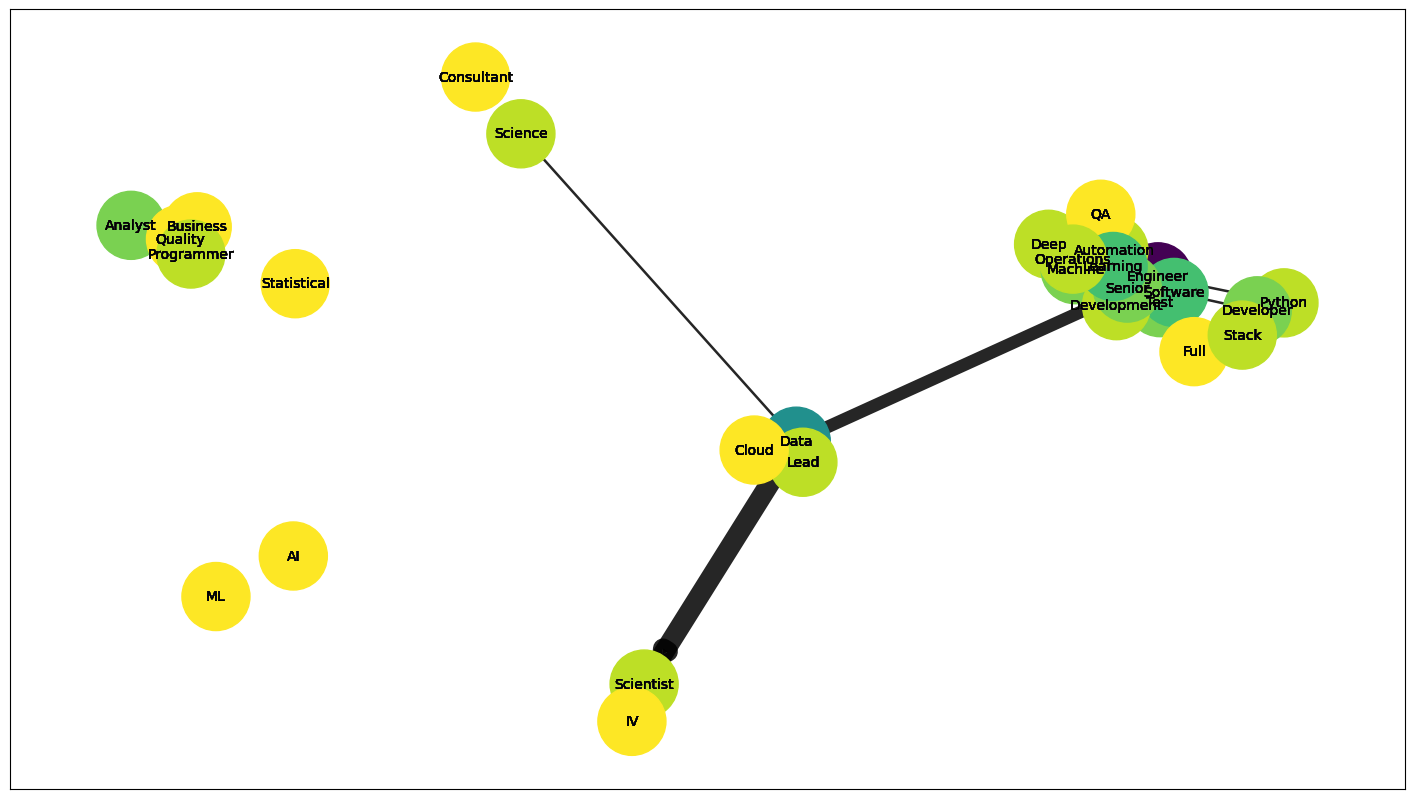

<Figure size 1800x800 with 0 Axes>

In [27]:

# Create a graph with just the well-used edges
import matplotlib.pyplot as plt

well_used_digraph = nx.DiGraph()
edge_tuples_list =[edge_tuple for edge_tuple in G.edges(data=True) if edge_tuple[2]['weight'] > 1] 
print(edge_tuples_list)
well_used_digraph.add_edges_from(edge_tuples_list)
fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
degree_dict = well_used_digraph.degree()
layout_dict = get_layout_dict(well_used_digraph)
pos_dict = layout_dict['fruchterman_reingold_layout']
draw_graph(well_used_digraph, pos_dict, degree_dict, ax=ax)

In [28]:

# Export the graph into Gephi
import pyperclip

gexf_dir = os.path.join(nu.saves_folder, 'gexf')
os.makedirs(name=gexf_dir, exist_ok=True)
gdf_dir = os.path.join(nu.saves_folder, 'gdf')
os.makedirs(name=gdf_dir, exist_ok=True)
file_name = 'well_used_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)
nx.write_gexf(well_used_digraph, file_path)
message_str = '''
1) Launch Gephi
2) In the File menu, open {}
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and save as {}
6) Repeat 2) through 5) as necessary
'''
abspath_str = os.path.abspath(file_path)
pyperclip.copy(abspath_str)
print(message_str.format(abspath_str, abspath_str.replace('gexf', 'gdf')))


1) Launch Gephi
2) In the File menu, open C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\gexf\well_used_digraph.gexf
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and save as C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\gdf\well_used_digraph.gdf
6) Repeat 2) through 5) as necessary



In [29]:

# Get the positional information that you exported from Gephi
import numpy as np

file_path = os.path.join(gdf_dir, 'well_used_digraph.gdf')
search_regex = re.compile(r"""^([^,]+),"\1",([.\d-]+),([.\d-]+),([.\d-]+),([.\d-]+),'([^']+)'(,0)?$""")
well_used_layout_dict = {}
with open(file_path) as file:
    for line in file:
        match_obj = search_regex.search(line)
        if match_obj:
            node_name = match_obj.group(1)
            node_x = match_obj.group(4)
            node_y = match_obj.group(5)
            well_used_layout_dict[node_name] = np.array([float(node_x), float(node_y)])
if set(well_used_digraph.nodes()) != set(well_used_layout_dict.keys()):
    display(set(well_used_digraph.nodes()).symmetric_difference(set(well_used_layout_dict.keys())))

In [30]:

# Create the double edge list
full_edge_list = list(well_used_digraph.edges())
double_edge_list = []
while len(full_edge_list) > 0:
    edge_tuple = full_edge_list.pop()
    doubled_tuple = (edge_tuple[1], edge_tuple[0])
    if doubled_tuple in full_edge_list:
        double_edge_list.append(edge_tuple)
        double_edge_list.append(doubled_tuple)

In [31]:

# Create the single edge list
single_edge_list = []
full_edge_list = list(well_used_digraph.edges())
for edge_tuple in full_edge_list:
    if edge_tuple not in double_edge_list:
        single_edge_list.append(edge_tuple)

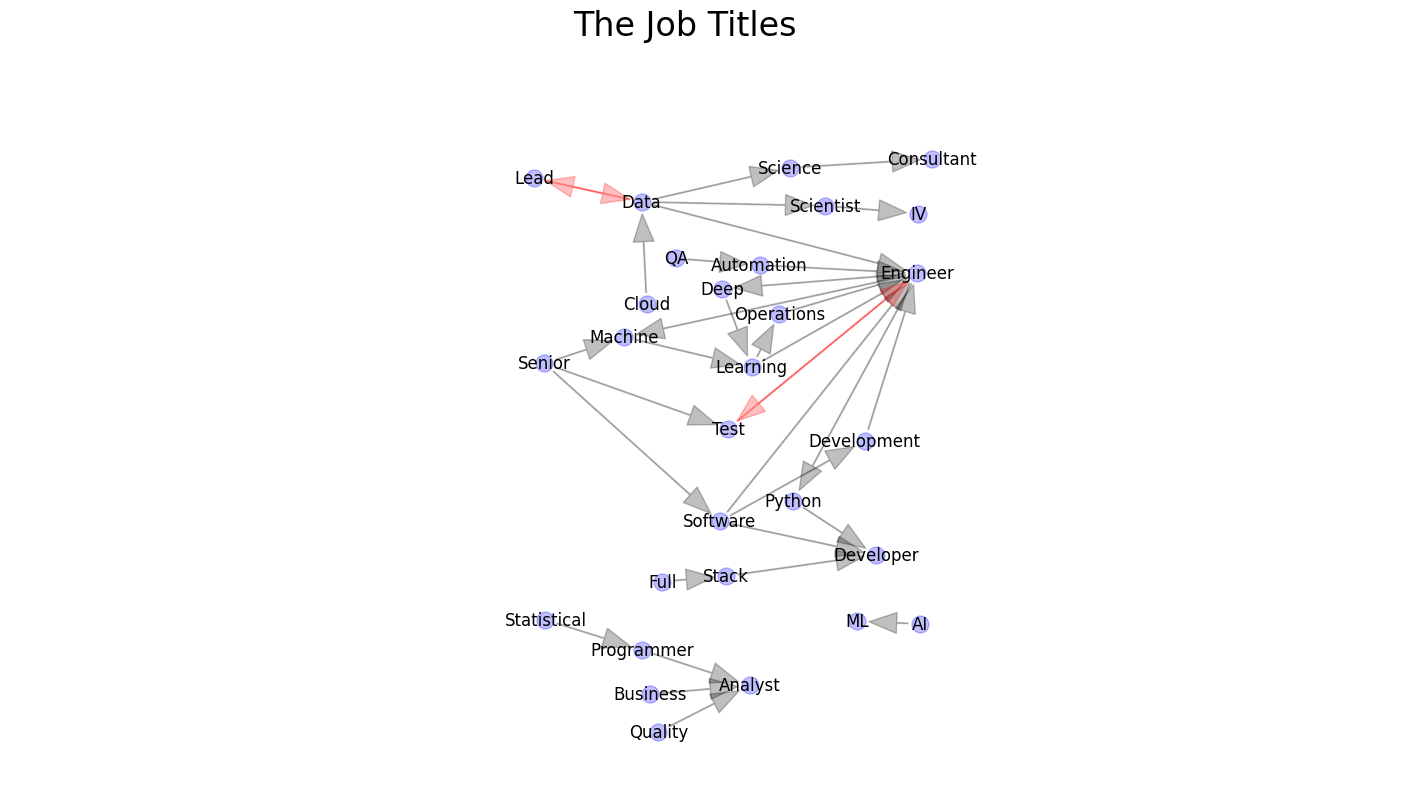

In [32]:

import matplotlib.patches as mpatches

# Draw the graph using the gephi layout
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)
plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])
fig.suptitle('The Job Titles', fontsize=24)

# Make fat arrows
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)

# Make the nodes blue so you can make the double edges red
node_collection = nx.draw_networkx_nodes(G=well_used_digraph, pos=well_used_layout_dict, alpha=0.25,
                                         node_color='b', node_size=150)

# Get the double-edged edge list in red
edge_collection = nx.draw_networkx_edges(G=well_used_digraph, pos=well_used_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=single_edge_list)
edge_collection = nx.draw_networkx_edges(G=well_used_digraph, pos=well_used_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=double_edge_list,
                                         edge_color='r')

labels_collection = nx.draw_networkx_labels(G=well_used_digraph, pos=well_used_layout_dict, font_size=12)
axes_subplot = fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1500, right=1500)

In [33]:

titles_regex = re.compile(r'\b(' + '|'.join(well_used_digraph.nodes()) + r')\b')
srs = Series(filename_jobtitles_list)
mask_series = srs.map(lambda x: bool(titles_regex.search(str(x))))
sorted(srs[mask_series].unique(), key=lambda x: len(x), reverse=True)

['Principal Statistical Programmer Associate Director of Programming', 'Senior Business Analyst Identity and Access Management', 'Senior Software Engineer Machine Learning Platform', 'Senior Machine Learning Engineer Machine Learning', 'Senior Software Developer AI Machine Learning', 'Director Senior Director Information Design', 'Senior Machine Learning Operations Engineer', 'Data Science Consulting Engagement Manager', 'Lead Data Scientist World Wide Technology', 'Software Development Engineer Test Senior', 'Senior Test Engineer Cloud Applications', 'Python Software Engineer Deep Learning', 'Tech Data Warehouse Operations Manager', 'ML AI Software Data Engineer w Python', 'Python Machine Learning Data Engineer', 'Senior Statistical Programmer Analyst', 'Business Analyst And Quality Analyst', 'Lead Data Scientist Machine Learning', 'Machine Learning Operations Engineer', 'Automation Engineer Python and yrs', 'Senior Software Engineer Solutions', 'Software Development Engineer Test', '

In [37]:

import pyttsx3

speech_engine = pyttsx3.init()
speech_str = 'Batch job complete'; speech_engine.say(speech_str); speech_engine.runAndWait()


----

In [ ]:

cypher_str = """
    // Get the file names of HTML strings that are Job Titles
    CALL {
        MATCH (np1:NavigableParents)-[r:NEXT]->(np2:NavigableParents)
        WHERE
            ((np1.is_header = false) AND (np1.is_job_title = true))
        RETURN
            r.file_name AS file_name,
            LEFT(np2.navigable_parent, 50) AS left_navigable_parent,
            LEFT(np1.navigable_parent, 50) AS middle_navigable_parent,
            NULL AS right_navigable_parent
    UNION
        MATCH (np2:NavigableParents)-[r:NEXT]->(np1:NavigableParents)
        WHERE
            ((np1.is_header = false) AND (np1.is_job_title = true))
        RETURN
            r.file_name AS file_name,
            LEFT(np2.navigable_parent, 50) AS left_navigable_parent,
            LEFT(np1.navigable_parent, 50) AS middle_navigable_parent,
            NULL AS right_navigable_parent
    }
    RETURN file_name, left_navigable_parent, middle_navigable_parent, right_navigable_parent;"""
row_objs_list = []
with cu.driver.session() as session:
        row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    middle_navigable_parents_df = DataFrame(row_objs_list)
    middle_navigable_parents_df['job_title'] = middle_navigable_parents_df.file_name.map(lambda file_name: su.get_job_title_from_file_name(file_name))
    middle_navigable_parents_df.job_title = middle_navigable_parents_df.job_title.map(lambda job_title: re.sub(r'(\d+ )+', '', job_title))
    middle_navigable_parents_df.job_title = middle_navigable_parents_df.job_title.map(lambda job_title: re.sub(r' Copy( \d\d)?', '', job_title))
    middle_navigable_parents_df.job_title = middle_navigable_parents_df.job_title.map(lambda job_title: re.sub('(?: remote){2}', ' Remote', job_title, 0, re.IGNORECASE))
    display(middle_navigable_parents_df)

In [ ]:

jobtitles_list = sorted([j for j in middle_navigable_parents_df.job_title.map(f).unique() if j])
df = nu.check_4_doubles(jobtitles_list).sort_values('max_similarity', ascending=False).head(20)
display(df)

In [ ]:

# jobtitles_set = set(item for inner_list in jobtitles_list for item in inner_list.split() if isinstance(item, str))
flattened_list = [string for inner_list in jobtitles_list for string in inner_list.split()]
srs = Series(flattened_list).value_counts()
srs[srs > 1].tail(20)

In [ ]:

srs[srs > 1].head(20)

In [ ]:

mask_series = middle_navigable_parents_df.job_title.map(lambda x: ' and ' in str(x))
middle_navigable_parents_df[mask_series].sample(4).T

In [ ]:

import networkx as nx

G = nx.DiGraph()
for job_title in jobtitles_list:
    title_words_list = job_title.split()
    for i in range(len(title_words_list) - 1):
        edge_tuple = (title_words_list[i], title_words_list[i + 1])
        if edge_tuple in G.edges(data=False):
            
            # Get the weight of the edge
            edge_data = G.get_edge_data(*edge_tuple)
            weight = edge_data.get('weight', 0)
        
            # Update the weight of the second edge
            G.edges[edge_tuple]['weight'] = weight + 1
        
        # Add an edge with weight
        else:
            G.add_edge(*edge_tuple, weight=1)

In [ ]:

degree_dict = G.degree()
degree_number_dict = {}
for display_str, degree_number in dict(degree_dict).items():
    degree_number_dict[degree_number] = degree_number_dict.get(degree_number, 0) + 1
degree_number_dict

In [ ]:

# Draw the graph
fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
degree_dict = G.degree()
layout_dict = get_layout_dict(G)
pos_dict = layout_dict['fruchterman_reingold_layout']
draw_graph(G, pos_dict, degree_dict, ax=ax)

In [ ]:

degree_dict

In [ ]:

[fn for fn in dir(G) if 'edge' in fn]

In [ ]:

# Create a graph with just the well-used edges
G1 = nx.DiGraph()
edge_tuples_list =[edge_tuple for edge_tuple in G.edges(data=True) if edge_tuple[2]['weight'] > 2] 
print(edge_tuples_list)
G1.add_edges_from(edge_tuples_list)
fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
degree_dict = G1.degree()
layout_dict = get_layout_dict(G1)
pos_dict = layout_dict['fruchterman_reingold_layout']
draw_graph(G1, pos_dict, degree_dict, ax=ax)

In [ ]:

nodes_regex = re.compile(r'\b(' + '|'.join(G1.nodes()) + r')\b')
mask_series = middle_navigable_parents_df.job_title.map(lambda x: bool(nodes_regex.search(str(x))))
sorted(middle_navigable_parents_df[mask_series].job_title.unique())

In [ ]:
 
def get_consecutive_pairs(jobtitles_list):
    pairs = []
    for i in range(len(jobtitles_list) - 1):
        pair = (jobtitles_list[i], jobtitles_list[i + 1])
        pairs.append(pair)
    
    return pairs

In [ ]:

tagged_jobtitles_list = sorted([j for j in middle_navigable_parents_df.middle_navigable_parent.map(f).unique() if j])
df = nu.check_4_doubles(tagged_jobtitles_list).sort_values('max_similarity', ascending=False).head(20)
display(df)

In [ ]:

sorted(tagged_jobtitles_list, key=lambda x: len(x))

In [ ]:

sorted(jobtitles_list, key=lambda x: len(x))

In [ ]:

for job_title in sorted(middle_navigable_parents_df.job_title.unique()):
    print(job_title)

In [ ]:

for row_dict in df.to_dict(orient='records'):
    print(row_dict)


## Option 1: Use a Hugging Face NER model

In [ ]:

from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

# Named entity recognition pipeline, passing in a specific model and tokenizer
model = AutoModelForTokenClassification.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
token_classifier = pipeline('ner', model=model, tokenizer=tokenizer)

# Example usage
sentence = 'Barack Obama was the 44th President of the United States.'
tokens = token_classifier(sentence)
print(tokens)


## Option 2: Use SpaCy

In [ ]:

import spacy

# Load the spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError as e:
    print(f"OSError while trying to spacy.load('en_core_web_sm'): {str(e).strip()}")
    command_str = f'{sys.executable} -m spacy download en_core_web_sm --quiet'
    print(command_str)
    !{command_str}
try:
    nlp = spacy.load('en_core_web_sm')
    import en_core_web_sm
    nlp = en_core_web_sm.load()
    
    # Example usage
    sentence = 'Barack Obama was the 44th President of the United States.'
    doc = nlp(sentence)
    print([{'text': word.text, 'tag_': word.tag_, 'ent_type_': word.ent_type_, 'pos_': word.pos_} for word in doc])
    print([{'text': ent.text, 'label_': ent.label_} for ent in doc.ents])
except Exception as e:
    print(f"{e.__class__.__name__} error while trying to load spacy again: {str(e).strip()}")


## Extract the text from the job_title column

In [ ]:

# load documents
rows_list = []
for text in middle_navigable_parents_df.job_title:
    text_length = len(text)
    
    # Prepare to join subword tokens back together and keep track of entity and score
    output_words = []
    current_word = ''
    current_entities = []
    current_scores = []
    current_starts = []
    current_ends = []
    
    # Extract metadata from entity recognition pipeline and add it as a row dictionary to the entities rows list
    tokens = token_classifier(text)
    for metadata_dict in tokens:
        current_entities.append(metadata_dict['entity'])
        current_scores.append(metadata_dict['score'])
        current_starts.append(metadata_dict['start'])
        current_ends.append(metadata_dict['end'])
        if metadata_dict['word'].startswith('##'): current_word += metadata_dict['word'][2:]
        else:
            
            # Take the mode of entities and average of scores for the current_word
            if current_word:
                if len(current_entities) > 1: current_entities = current_entities[:-1]
                if len(current_scores) > 1: current_scores = current_scores[:-1]
                if len(current_ends) > 2: current_ends = current_ends[:-1]
                mode_entity = Series(current_entities).mode().tolist()[-1]
                mean_score = Series(current_scores).mean()
                start_idx = current_starts[0]
                end_idx = current_ends[-1]
                entity_tuple = (current_word, mode_entity, mean_score, start_idx, end_idx)
                output_words.append(entity_tuple)
                current_word = ''
                current_entities = []
                current_scores = []
                current_starts = []
                current_ends = []
            else:
                current_word = metadata_dict['word']
                current_entities = [metadata_dict['entity']]
                current_scores = [metadata_dict['score']]
                current_starts = [metadata_dict['start']]
                current_ends = [metadata_dict['end']]
    
    # Take the mode of entities for the last current_word
    if current_word:
        mode_entity = Series(current_entities).mode().tolist()[-1]
        mean_score = Series(current_scores).mean()
        start_idx = current_starts[0]
        end_idx = current_ends[-1]
        entity_tuple = (current_word, mode_entity, mean_score, start_idx, end_idx)
        output_words.append(entity_tuple)
    
    # Extract metadata from entity recognition pipeline and add it as a row dictionary to the entities rows list
    for word, entity, score, start, end in output_words:
        metadata_dict = {
            'bert_word': word, 'bert_entity': entity, 'bert_score': score, 'bert_start': start, 'bert_end': end, 'job_title': text
        }
        rows_list.append(metadata_dict)

    # Extract SpaCy named entities and add them as a row dictionary to the entities rows list
    if text_length <= nlp.max_length:
        doc = nlp(text)
        rows_list.extend([
            {'job_title': text, 'nlp_word': word.text, 'nlp_tag': word.tag_, 'nlp_type': word.ent_type_, 'nlp_pofs': word.pos_}
            for word in doc
        ])
        rows_list.extend([
            {'job_title': text, 'ent_phrase': ent.text, 'ent_type': ent.label_, 'ent_start': ent.start_char, 'ent_end': ent.end_char}
            for ent in doc.ents
        ])
job_title_ners_df = DataFrame(rows_list)

In [ ]:

import random

# Perform the groupby operation and convert the groupby object to a list of tuples (job_title, job_title_df)
grouped_list = list(job_title_ners_df.groupby('job_title'))

In [ ]:

# Randomly select one tuple from the list
random_job_title, random_job_title_df = random.choice(grouped_list)

# Now 'random_job_title_df' is the randomly selected DataFrame
mask_series = ~random_job_title_df.ent_phrase.isnull()
if mask_series.any():
    print(random_job_title)
    display(random_job_title_df[mask_series].dropna(axis='columns', how='all'))

In [ ]:

random_job_title_df

In [ ]:

from geotext import GeoText

print(random_job_title)
places = GeoText(random_job_title)
print(places.cities)
print(places.countries)
print(places.country_mentions)

In [ ]:

# Get job titles that have numbers in them
mask_series = (job_title_ners_df.nlp_pofs == 'NUM')
job_titles_with_numbers = sorted(job_title_ners_df[mask_series].job_title.unique())

In [ ]:

Remove numbers from job titles in the 

In [ ]:

mask_series = (job_title_ners_df.nlp_pofs == 'NUM')
for job_title in sorted(job_title_ners_df[~mask_series].job_title.unique()):
    places = GeoText(job_title)
    cities_list = places.cities
    if cities_list:
        print(job_title, cities_list)

In [ ]:

mask_series = (job_title_ners_df.nlp_pofs == 'NUM')
df = job_title_ners_df[mask_series].sort_values('nlp_word').dropna(axis='columns', how='all')
print(len(df.job_title.unique()))
display(df.sample(10).T)

In [ ]:

mask_series = (job_title_ners_df.nlp_tag == 'CD')
df = job_title_ners_df[mask_series].sort_values('nlp_word').dropna(axis='columns', how='all')
print(len(df.job_title.unique()))
display(df.sample(10).T)

In [ ]:

mask_series = job_title_ners_df.bert_word.isnull()
df = job_title_ners_df[~mask_series].sort_values('bert_word').dropna(axis='columns', how='all')
print(len(df.job_title.unique()))
display(df.sample(10).T)

In [ ]:

mask_series = (job_title_ners_df.bert_entity == 'I-ORG') | job_title_ners_df.bert_word.isnull()
df = job_title_ners_df[~mask_series].sort_values('bert_word').dropna(axis='columns', how='all')
print(len(df.job_title.unique()))
display(df.sample(10).T)


# Maintenance

In [ ]:

raise

In [ ]:

# mask_series = (df.char_count > 165)
for child_str in df.iloc[637:642].middle_navigable_parent:
    def do_cypher_tx(tx, navigable_parent):
        cypher_str = """
    // Set the is_job_title to false
    MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
    SET np.is_job_title = false
    """ + cu.return_every_np_str + ';'
        print(cypher_str.replace('$navigable_parent', f'"{child_str}"'))
        return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
    with cu.driver.session() as session:
        row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str)
    # display(DataFrame(row_objs_list).T)
    # break

In [ ]:

cypher_str = """
// Get all distinct node types and property names
CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName
RETURN DISTINCT nodeType, propertyName;"""
row_objs_list = []
with cu.driver.session() as session: row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list)
    df.nodeType = df.nodeType.map(lambda x: re.sub('[^A-Za-z]+', '', str(x)))
    display(df)

In [ ]:

mask_series = df.propertyName.map(lambda x: 'job' in str(x))
df[mask_series]

In [ ]:

cypher_str = """
// Get all node types that have the is_job_title property defined
CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName
WHERE propertyName = "is_job_title"
RETURN DISTINCT nodeType;"""
row_objs_list = []
with cu.driver.session() as session: row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list)
    display(df)

In [ ]:

cypher_str = """
    // Get all the HTML strings that are considered job titles
    MATCH (np:NavigableParents)
    WHERE
        (np.is_job_title = true)
        AND (np.is_header = false)
    RETURN
        np.is_corporate_scope AS is_corporate_scope,
        np.is_educational_requirement AS is_educational_requirement,
        np.is_header AS is_header,
        np.is_interview_procedure AS is_interview_procedure,
        np.is_job_duration AS is_job_duration,
        np.is_job_title AS is_job_title,
        np.is_legal_notification AS is_legal_notification,
        np.is_minimum_qualification AS is_minimum_qualification,
        np.is_office_location AS is_office_location,
        np.is_other AS is_other,
        np.is_posting_date AS is_posting_date,
        np.is_preferred_qualification AS is_preferred_qualification,
        np.is_supplemental_pay AS is_supplemental_pay,
        np.is_task_scope AS is_task_scope,
        np.navigable_parent AS navigable_parent
    ORDER BY size(np.navigable_parent) ASC;"""
row_objs_list = []
with cu.driver.session() as session:
        row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list)
    df['char_count'] = df.navigable_parent.map(lambda x: len(str(x)))
    columns_list = ['navigable_parent', 'is_header', 'char_count']
    display(df[columns_list].sort_values('char_count'))

In [ ]:

# mask_series = (df.char_count > 165)
for child_str in df.iloc[9939:9940].navigable_parent:
    def do_cypher_tx(tx, navigable_parent):
        cypher_str = """
    // Set the is_job_title to false
    MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
    SET np.is_job_title = false
    """ + cu.return_every_np_str + ';'
        print(cypher_str.replace('$navigable_parent', f'"{child_str}"'))
        return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
    with cu.driver.session() as session:
        row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str)
    # display(DataFrame(row_objs_list).T)
    # break

In [ ]:

cypher_str = """
    // Set the is_job_title to false
    MATCH (np:NavigableParents)
    WHERE np.navigable_parent CONTAINS "Sr. NLP Researcher"
    SET np.is_job_title = true
    RETURN
        np.navigable_parent AS navigable_parent,
        np.is_header AS is_header,
        np.is_task_scope AS is_task_scope,
        np.is_minimum_qualification AS is_minimum_qualification,
        np.is_preferred_qualification AS is_preferred_qualification,
        np.is_legal_notification AS is_legal_notification,
        np.is_job_title AS is_job_title,
        np.is_office_location AS is_office_location,
        np.is_job_duration AS is_job_duration,
        np.is_supplemental_pay AS is_supplemental_pay,
        np.is_educational_requirement AS is_educational_requirement,
        np.is_interview_procedure AS is_interview_procedure,
        np.is_corporate_scope AS is_corporate_scope,
        np.is_posting_date AS is_posting_date,
        np.is_other AS is_other;"""
row_objs_list = []
with cu.driver.session() as session: row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list)
    display(df.T)

In [ ]:

cypher_str = """
// Get all node types that have a file property defined
CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName
WHERE propertyName CONTAINS "file"
RETURN DISTINCT nodeType, propertyName;"""
row_objs_list = []
with cu.driver.session() as session:
        row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list)
    display(df)